In [56]:
#Import relevant libraries
import matplotlib.pyplot as plt
import numpy as np, pandas as pd
import seaborn as sns
import sklearn

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import scale

In [57]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [58]:
#Load NSF Awards Dataset. This dataset consists of awards in AI and ML that NSF awarded in 2019-2020

data = pd.read_excel("/content/drive/MyDrive/Grad School-Files/Job Search/Data Science Basics/HousePricePrediction.xlsx")
data = data.dropna(axis=0) #drop null rows

In [59]:
#Print info
print(data.info())

#Is there null data in the dataframe?
print(data.isnull().sum())

#Is there duplicated data in the data frame?
print(data.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 0 to 1459
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Id            1460 non-null   int64  
 1   MSSubClass    1460 non-null   int64  
 2   MSZoning      1460 non-null   object 
 3   LotArea       1460 non-null   int64  
 4   LotConfig     1460 non-null   object 
 5   BldgType      1460 non-null   object 
 6   OverallCond   1460 non-null   int64  
 7   YearBuilt     1460 non-null   int64  
 8   YearRemodAdd  1460 non-null   int64  
 9   Exterior1st   1460 non-null   object 
 10  BsmtFinSF2    1460 non-null   float64
 11  TotalBsmtSF   1460 non-null   float64
 12  SalePrice     1460 non-null   float64
dtypes: float64(3), int64(6), object(4)
memory usage: 159.7+ KB
None
Id              0
MSSubClass      0
MSZoning        0
LotArea         0
LotConfig       0
BldgType        0
OverallCond     0
YearBuilt       0
YearRemodAdd    0
Exterior1st     0

In [60]:
# Get numerical variables
cont_data = data.select_dtypes(include=np.number)

#Drop some of the numerical categorical columns
cont_data = cont_data.drop(columns=['OverallCond', 'MSSubClass'])
cont_data.head()

,Id,LotArea,YearBuilt,YearRemodAdd,BsmtFinSF2,TotalBsmtSF,SalePrice
0,0,8450,2003,2003,0.0,856.0,208500.0
1,1,9600,1976,1976,0.0,1262.0,181500.0
2,2,11250,2001,2002,0.0,920.0,223500.0
3,3,9550,1915,1970,0.0,756.0,140000.0
4,4,14260,2000,2000,0.0,1145.0,250000.0


## 1. Exploratory Analysis

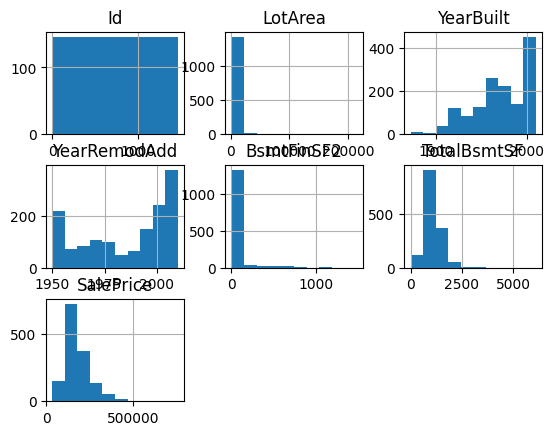

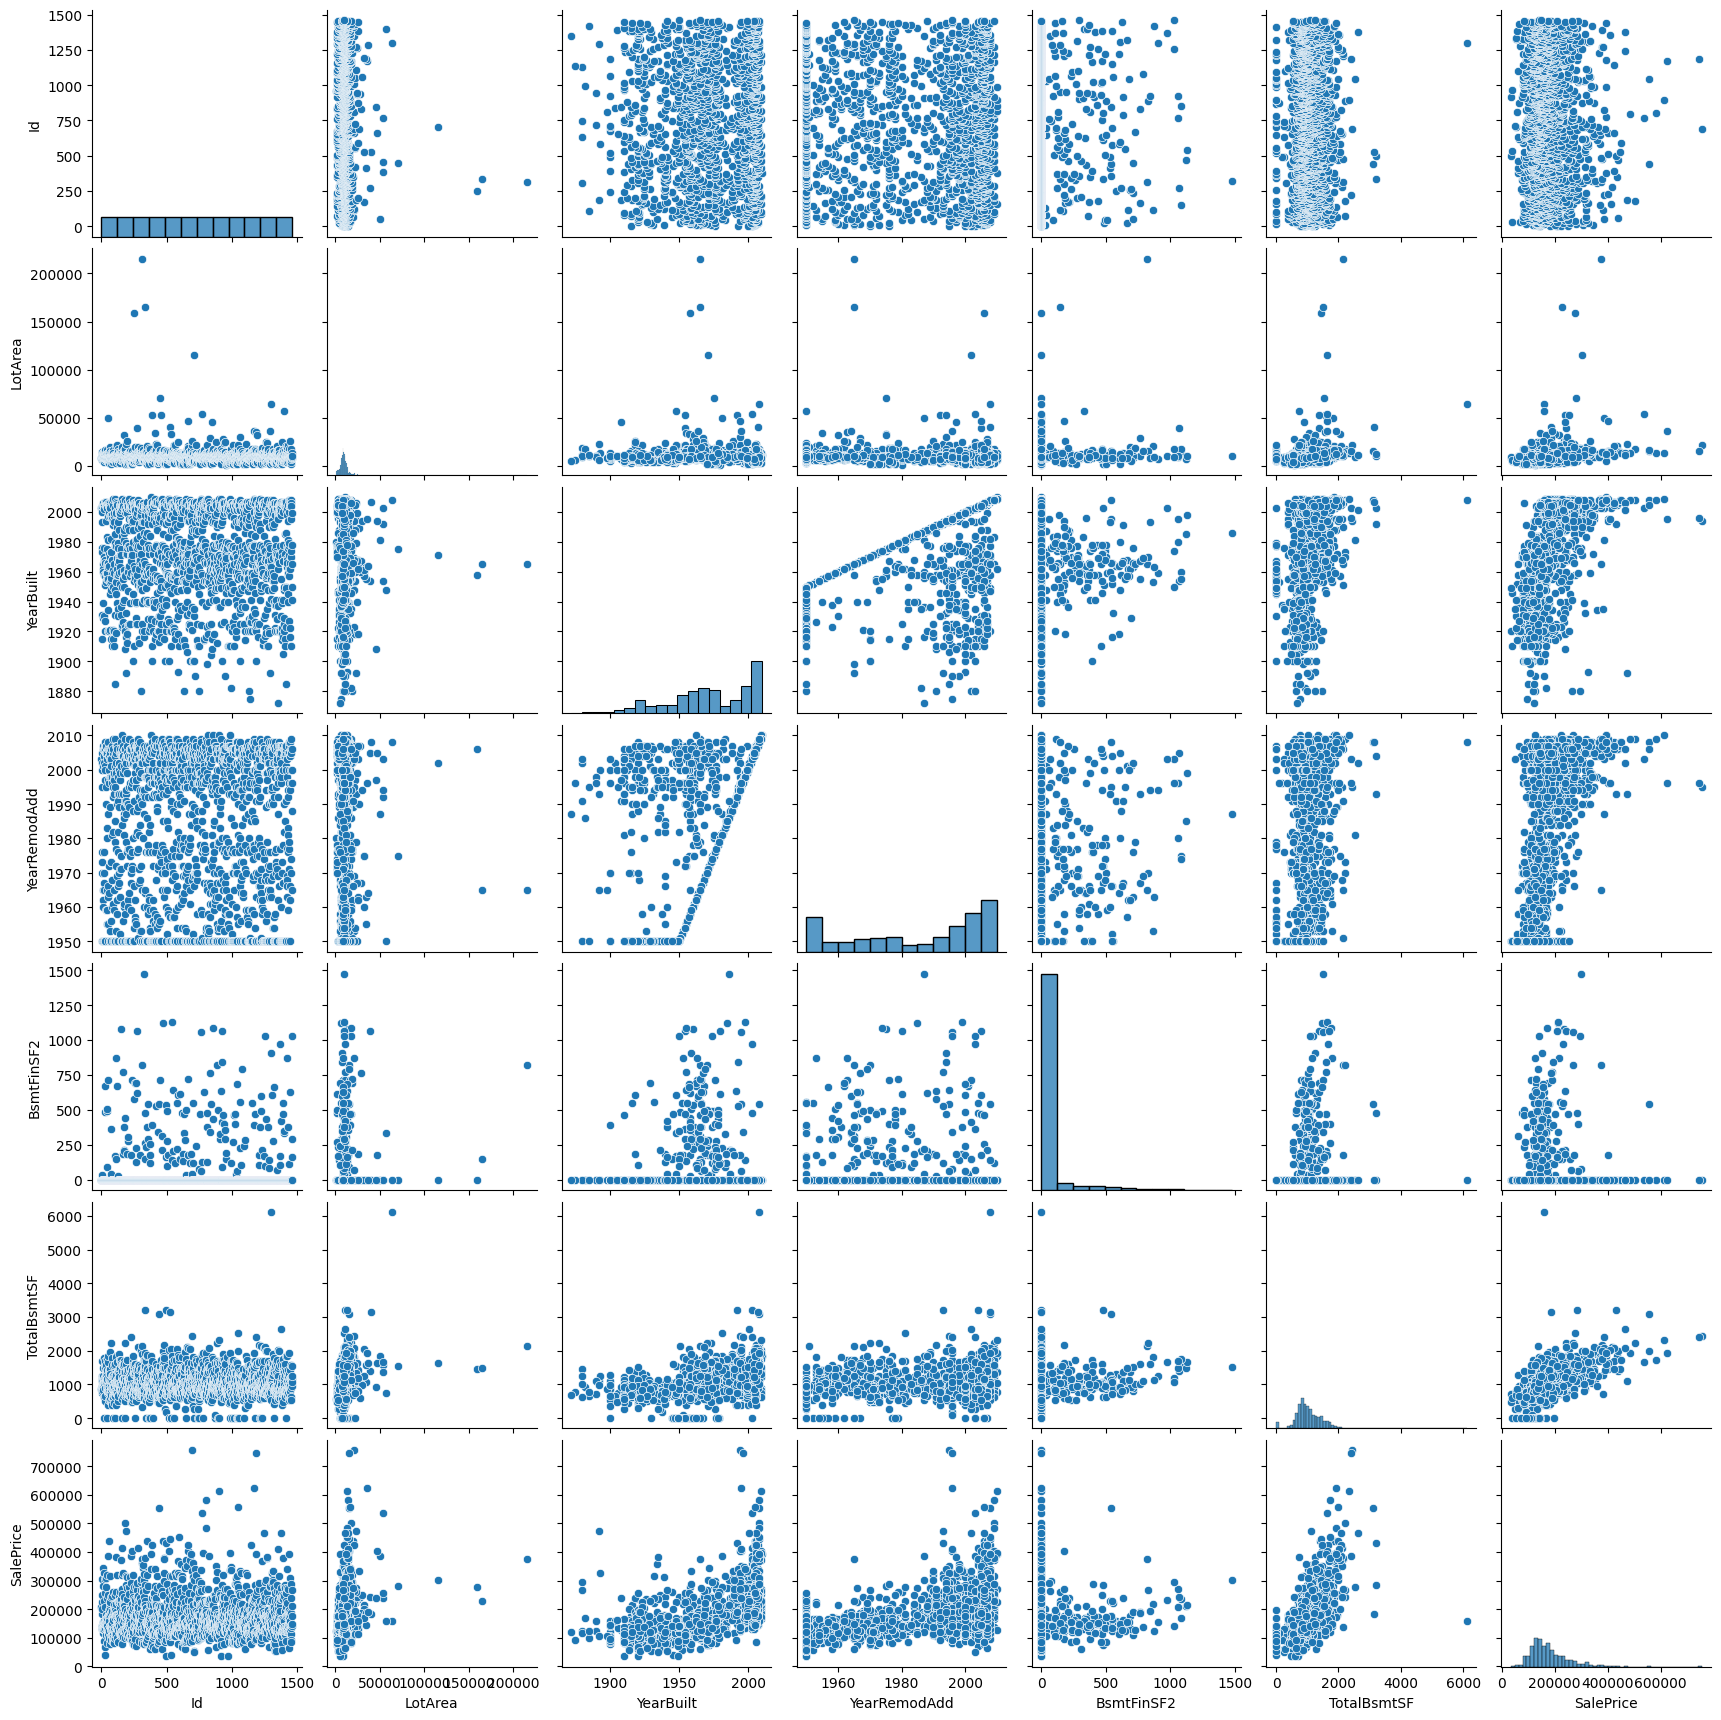

In [61]:
#Plot histograms
cont_data.hist()

#Plot pair plots to look at relationship between variables
sns.pairplot(cont_data)

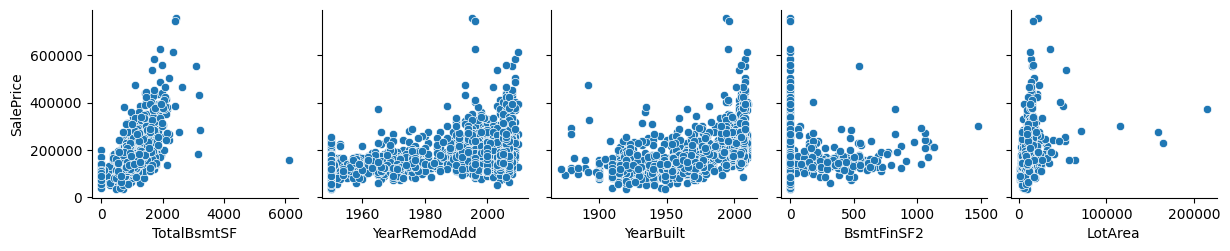

In [62]:
#We care about predicting sale price, so let's plot that against all other numeric variables
sns.pairplot(
    data,
    x_vars=['TotalBsmtSF', 'YearRemodAdd', 'YearBuilt', 'BsmtFinSF2', 'LotArea'],
    y_vars=["SalePrice"],
)


It seems like SalePrice might be linearly associated with TotalBsmtSF, YearRemodAdd and YearBuilt.

<Axes: >

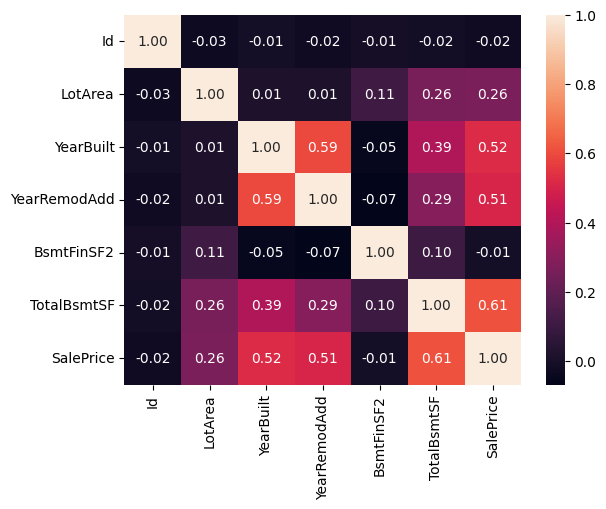

In [63]:
#Let's look at the correlations
corr_plot = cont_data.corr()

#Plot correlations on a heatmap
sns.heatmap(corr_plot, annot=True, fmt='.2f')

The above hypothesis is somewhat confirmed when looking at the heatmap that SalePrice is positivelt correlated with TotalBsmtSF, YearBuilt and YearRemodAdd. Something to keep in mind is that YearBuilt and YearRemodAdd are also correlated with each other, this means that these two variables may not be independent of each other. This makes sense as the newer the house, the less likely it is to be remodeled.

#. Simple Linear Regression

Let's look at a linear regession model of the SalePrice and TotalBsmtSF

In [87]:
#Extract independent and dependent variable
X = np.asarray(cont_data['TotalBsmtSF'].values).reshape((-1,1))
y = np.asarray(cont_data['SalePrice'].values).reshape(-1,1)

#Scale variables
X,y = scale(X), scale(y)

In [88]:
#Instantiate Linear Regresson model
lr = LinearRegression()

#Fit model to data
lr.fit(X,y)

print(lr.intercept_, lr.coef_)
print('R62 score: %0.3f' %  lr.score(X,y))

[-1.45311725e-17] [[0.61358055]]
R62 score: 0.376


The R^2 score is pretty low indicating that the TotalBsmtSF by itself does not explain a lot of the variance in SalePrice and may not be a very good predictor of SalePrice if we use Linear Regression. Let's try to see this in action by training a regression model on some data and testing it to measure accuracy

In [89]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import math

#Define model
lr = LinearRegression()
#Define cross-validation method to use with 5 folds
cv = KFold(n_splits=5, random_state=1, shuffle=True)
#use k-fold CV to evaluate model
scores = cross_val_score(lr, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
#view mean absolute error
print('Mean squared error: ', abs(scores).mean())

Mean squared error:  0.6336350443612625


# Multivariate Linear Regression

The above MSE value shows that the univariate linear regression was not too bad at estimating the SalePrice. Let's add the YearBuilt and YearRemodAdd as well to see whether we can improve the performance of the model. Note that this won't be perfect as YearBuilt and YearRemodAdd are correlated.

In [94]:
#Extract independent and dependent variable
X = cont_data[['TotalBsmtSF', 'YearBuilt', 'YearRemodAdd']]
y = np.asarray(cont_data['SalePrice'].values).reshape(-1,1)

#Scale variables
X,y = scale(X), scale(y)

In [95]:
#Instantiate Linear Regresson model
lr = LinearRegression()

#Fit model to data
lr.fit(X,y)

print(lr.intercept_, lr.coef_)
print('R62 score: %0.3f' %  lr.score(X,y))

[-1.34904579e-15] [[0.46465778 0.1858839  0.26165288]]
R62 score: 0.515


The R^2 score is now slightly higher indicating that the three variables together explain a little more variance in SalePrice

In [96]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import math

#Define model
lr = LinearRegression()
#Define cross-validation method to use with 5 folds
cv = KFold(n_splits=5, random_state=1, shuffle=True)
#use k-fold CV to evaluate model
scores = cross_val_score(lr, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
#view mean absolute error
print('Mean squared error: ', abs(scores).mean())

Mean squared error:  0.4951675944471125


Now, what if we use all the numerical variables to predict SalePrice

In [103]:
#Extract independent and dependent variable
X = cont_data[['TotalBsmtSF', 'YearBuilt', 'YearRemodAdd', 'LotArea', 'BsmtFinSF2']]
y = np.asarray(cont_data['SalePrice'].values).reshape(-1,1)

#Scale variables
X,y = scale(X), scale(y)

#Instantiate Linear Regresson model
lr = LinearRegression()

#Fit model to data
lr.fit(X,y)

print(lr.intercept_, lr.coef_)
print('R62 score: %0.3f' %  lr.score(X,y))

[-1.3419377e-15] [[ 0.42568669  0.19699759  0.26123877  0.15145868 -0.04545669]]
R62 score: 0.537


There is slight increase in R^2 but not much

In [105]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import math

#Define model
lr = LinearRegression()
#Define cross-validation method to use with 5 folds
cv = KFold(n_splits=5, random_state=1, shuffle=True)
#use k-fold CV to evaluate model
scores = cross_val_score(lr, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
#view mean absolute error
print('Mean squared error: ', abs(scores).mean())

TypeError: ignored